In [2]:
# !pip install numba

In [4]:
# !pip install networkx
# !pip install scipy

In [6]:
#!pip install matplotlib

In [8]:
 #!pip install seaborn

In [10]:
 #!pip install joblib

In [11]:
from numba import njit, prange
import numpy as np
from joblib import Parallel, delayed
import pandas as pd
import seaborn as sns
import networkx as nx
from scipy.stats import powerlaw
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


@njit(cache=True)
def calculate_stress_numba(opinions_node, opinions_neighbors, relationships, alpha, G):
    """Fast stress calculation using only arrays"""
    n_neighbors = len(relationships)
    stress = 0.0
    
    for i in range(n_neighbors):
        alignment = 0.0
        for g in range(G):
            alignment += opinions_node[g] * opinions_neighbors[g, i]
        alignment /= G
        
        if relationships[i] == 1:  # friend
            stress -= alpha * alignment
        else:  # enemy
            stress += (1 - alpha) * alignment
    
    return stress

@njit(cache=True)
def compute_delta_stress(opinions, node, flip_idx, neighbor_indices, neighbor_counts,
                         relationships_flat, alpha, G, N, max_neighbors):
    """Compute stress change from flipping one opinion - fully compiled"""
    n_neighbors = neighbor_counts[node]
    if n_neighbors == 0:
        return 0.0
    
    start_idx = node * max_neighbors
    
    delta_stress = 0.0
    old_val = opinions[flip_idx, node]
    delta_opinion = -2 * old_val  # Change from old to new value
    
    for i in range(n_neighbors):
        neighbor = neighbor_indices[start_idx + i]
        rel = relationships_flat[start_idx + i]
        
        # Only the flipped opinion contributes to delta
        neighbor_opinion = opinions[flip_idx, neighbor]
        delta_alignment = delta_opinion * neighbor_opinion / G
        
        if rel == 1:  # friend
            delta_stress -= alpha * delta_alignment
        else:  # enemy
            delta_stress += (1 - alpha) * delta_alignment
    
    return delta_stress

@njit(cache=True)
def update_relationships_for_node(opinions, node, neighbor_indices, neighbor_counts,
                                   relationships_flat, G, max_neighbors):
    """Update relationships after opinion change"""
    n_neighbors = neighbor_counts[node]
    start_idx = node * max_neighbors
    
    for i in range(n_neighbors):
        neighbor = neighbor_indices[start_idx + i]
        
        # Compute dot product
        dot_product = 0.0
        for g in range(G):
            dot_product += opinions[g, node] * opinions[g, neighbor]
        
        # Update relationship: positive dot -> friend (1), else enemy (-1)
        new_rel = 1 if dot_product > 0 else -1
        relationships_flat[start_idx + i] = new_rel
        
        # Also update the reverse direction
        neighbor_start = neighbor * max_neighbors
        neighbor_count = neighbor_counts[neighbor]
        for j in range(neighbor_count):
            if neighbor_indices[neighbor_start + j] == node:
                relationships_flat[neighbor_start + j] = new_rel
                break

@njit(cache=True, parallel=False)
def run_mc_steps(opinions, neighbor_indices, neighbor_counts, relationships_flat,
                 instigators, alpha, beta, G, N, max_neighbors, n_steps):
    """Run Monte Carlo simulation steps - fully JIT compiled"""
    mc_step = N * G
    
    for step in range(n_steps):
        for _ in range(mc_step):
            # Pick random node
            node = np.random.randint(0, N)
            
            # Skip instigators
            if instigators[node]:
                continue
            
            # Pick random opinion to flip
            flip_idx = np.random.randint(0, G)
            
            # Compute delta stress
            delta_stress = compute_delta_stress(
                opinions, node, flip_idx, neighbor_indices, neighbor_counts,
                relationships_flat, alpha, G, N, max_neighbors
            )
            
            # Metropolis acceptance
            if delta_stress <= 0 or np.random.random() < np.exp(-beta * delta_stress):
                # Accept: flip the opinion
                opinions[flip_idx, node] *= -1
                # Update relationships
                update_relationships_for_node(
                    opinions, node, neighbor_indices, neighbor_counts,
                    relationships_flat, G, max_neighbors
                )

@njit(cache=True)
def compute_polarization_samples(opinions, G, N, num_samples):
    """Compute polarization samples"""
    samples = np.empty(num_samples)
    
    for s in range(num_samples):
        # Sample two different nodes
        i = np.random.randint(0, N)
        j = np.random.randint(0, N - 1)
        if j >= i:
            j += 1
        
        # Count matching opinions
        matches = 0
        for g in range(G):
            if opinions[g, i] == opinions[g, j]:
                matches += 1
        
        samples[s] = matches / G
    
    # Compute variance
    mean = 0.0
    for s in range(num_samples):
        mean += samples[s]
    mean /= num_samples
    
    var = 0.0
    for s in range(num_samples):
        var += (samples[s] - mean) ** 2
    var /= num_samples
    
    return 4 * var

In [12]:
class PolarizationModelFast:
    """
    Optimized Polarization Model using Numba JIT compilation.
    All simulation loops run in compiled code for ~50-100x speedup.
    """
    def __init__(self, N,
            lambda_avg,
            epsilon,
            G,
            alpha,
            beta,
            gamma=0.0,
            eta=0.5,
            symmetric_influencers=True,
            num_samples=1000,
            network_type='poisson'):
        
        self.N = N
        self.lambda_avg = lambda_avg
        self.epsilon = epsilon
        self.G = G
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.eta = eta
        self.symmetric_influencers = symmetric_influencers
        self.num_samples = num_samples
        self.network_type=network_type

        # Build network and convert to flat arrays for Numba
        self.network, self.desired_degrees = self._init_network()
        self._build_neighbor_arrays()

        # Initialize opinions and instigators
        self._init_instigators_and_opinions()

        # Initialize relationships as flat array
        self._init_relationships()

        # Activate instigators
        if self.gamma > 0:
            self._activate_instigators()

        self.polarizations = []

    def _init_network(self):
        """Create Poissonian small-world network"""
        if self.network_type=='poisson':
            desired_degrees = np.random.poisson(self.lambda_avg, self.N)
        elif self.network_type=='power':
            # desired_degrees = powerlaw.rvs(a=self.lambda_avg, size=self.N)
            desired_degrees = powerlaw.rvs(a=2.5, size=self.N)
            desired_degrees = (desired_degrees * self.lambda_avg).astype(int)
        adjacency_list = {i: set() for i in range(self.N)}
        
        nodes_shuffled = list(range(self.N))
        np.random.shuffle(nodes_shuffled)
        
        for i in nodes_shuffled:
            d = desired_degrees[i]
            k = 1
            while len(adjacency_list[i]) < d:
                neighbor1 = (i + k) % self.N
                neighbor2 = (i - k) % self.N
                
                if len(adjacency_list[i]) < d and len(adjacency_list[neighbor1]) < desired_degrees[neighbor1]:
                    adjacency_list[i].add(neighbor1)
                    adjacency_list[neighbor1].add(i)
                
                if len(adjacency_list[i]) < d and len(adjacency_list[neighbor2]) < desired_degrees[neighbor2]:
                    adjacency_list[i].add(neighbor2)
                    adjacency_list[neighbor2].add(i)
                
                k += 1
                if k > self.N // 2:
                    break
        
        # Small-world rewiring
        for node in range(self.N):
            neighbors = list(adjacency_list[node])
            for neighbor in neighbors:
                if node < neighbor and np.random.random() < self.epsilon:
                    adjacency_list[node].discard(neighbor)
                    adjacency_list[neighbor].discard(node)
                    possible = [n for n in range(self.N) if n != node and n not in adjacency_list[node]]
                    if possible:
                        new_neighbor = np.random.choice(possible)
                        adjacency_list[node].add(new_neighbor)
                        adjacency_list[new_neighbor].add(node)
        
        # Convert to NetworkX for component analysis
        graph = nx.Graph()
        graph.add_nodes_from(range(self.N))
        for node, neighbors in adjacency_list.items():
            for neighbor in neighbors:
                graph.add_edge(node, neighbor)
        
        # Connect components
        components = list(nx.connected_components(graph))
        if len(components) > 1:
            largest_comp = max(components, key=len)
            largest_list = list(largest_comp)
            for comp in components:
                if comp is not largest_comp:
                    small_node = np.random.choice(list(comp))
                    best_node = min(largest_list,
                                   key=lambda x: min(abs(x - small_node), self.N - abs(x - small_node)))
                    graph.add_edge(small_node, best_node)
        
        return graph, desired_degrees

    def _build_neighbor_arrays(self):
        """Convert network to flat arrays for Numba - key optimization!"""
        # Find max degree for array sizing
        self.max_neighbors = max(dict(self.network.degree()).values()) + 1
        
        # Flat arrays: neighbor_indices[node * max_neighbors + i] = i-th neighbor of node
        self.neighbor_indices = np.zeros(self.N * self.max_neighbors, dtype=np.int32)
        self.neighbor_counts = np.zeros(self.N, dtype=np.int32)
        
        for node in range(self.N):
            neighbors = list(self.network.neighbors(node))
            self.neighbor_counts[node] = len(neighbors)
            start_idx = node * self.max_neighbors
            for i, neighbor in enumerate(neighbors):
                self.neighbor_indices[start_idx + i] = neighbor
        
        # Relationships stored the same way
        self.relationships_flat = np.zeros(self.N * self.max_neighbors, dtype=np.int8)

    def _init_instigators_and_opinions(self):
        """Initialize instigators and opinions"""
        I = int(round(self.N * self.gamma))
        self.instigators = np.zeros(self.N, dtype=np.bool_)
        
        if I > 0:
            self.instigator_indices = np.random.choice(self.N, size=I, replace=False)
            self.instigators[self.instigator_indices] = True
            
            if self.symmetric_influencers:
                base = np.where(np.random.rand(I) < 0.5, -1, 1).astype(np.float64)
                self.instigator_opinion = np.repeat(base.reshape(1, -1), self.G, axis=0)
            else:
                self.instigator_opinion = np.ones((self.G, I), dtype=np.float64)
        else:
            self.instigator_indices = np.array([], dtype=np.int32)
            self.instigator_opinion = np.zeros((self.G, 0), dtype=np.float64)
        
        # Initial opinions
        self.opinions = np.where(
            np.random.rand(self.G, self.N) < self.eta, -1.0, 1.0
        ).astype(np.float64)

    def _init_relationships(self):
        """Initialize relationships based on initial opinions"""
        for node in range(self.N):
            n_neighbors = self.neighbor_counts[node]
            start_idx = node * self.max_neighbors
            
            for i in range(n_neighbors):
                neighbor = self.neighbor_indices[start_idx + i]
                if node < neighbor:  # Only compute once per edge
                    dot_product = np.dot(self.opinions[:, node], self.opinions[:, neighbor])
                    rel = 1 if dot_product > 0 else -1
                    
                    # Set for this node
                    self.relationships_flat[start_idx + i] = rel
                    
                    # Set for neighbor
                    neighbor_start = neighbor * self.max_neighbors
                    for j in range(self.neighbor_counts[neighbor]):
                        if self.neighbor_indices[neighbor_start + j] == node:
                            self.relationships_flat[neighbor_start + j] = rel
                            break

    def _activate_instigators(self):
        """Set instigator opinions and update their relationships"""
        for col_idx, node in enumerate(self.instigator_indices):
            self.opinions[:, node] = self.instigator_opinion[:, col_idx]
            
            # Update relationships for this instigator
            n_neighbors = self.neighbor_counts[node]
            start_idx = node * self.max_neighbors
            
            for i in range(n_neighbors):
                neighbor = self.neighbor_indices[start_idx + i]
                dot_product = np.dot(self.opinions[:, node], self.opinions[:, neighbor])
                rel = 1 if dot_product > 0 else -1
                
                self.relationships_flat[start_idx + i] = rel
                
                neighbor_start = neighbor * self.max_neighbors
                for j in range(self.neighbor_counts[neighbor]):
                    if self.neighbor_indices[neighbor_start + j] == node:
                        self.relationships_flat[neighbor_start + j] = rel
                        break

    def run_simulation(self, n_steps):
        """Run simulation using optimized Numba functions"""
        run_mc_steps(
            self.opinions,
            self.neighbor_indices,
            self.neighbor_counts,
            self.relationships_flat,
            self.instigators,
            self.alpha,
            self.beta,
            self.G,
            self.N,
            self.max_neighbors,
            n_steps
        )

    def calculate_polarization(self):
        """Calculate polarization using optimized function"""
        return compute_polarization_samples(self.opinions, self.G, self.N, self.num_samples)

    def get_positive_degree(self):
        """Calculate average positive degree <k+>"""
        positive_count = 0
        for node in range(self.N):
            n_neighbors = self.neighbor_counts[node]
            start_idx = node * self.max_neighbors
            for i in range(n_neighbors):
                if self.relationships_flat[start_idx + i] == 1:
                    positive_count += 1
        return positive_count / self.N

    def run_and_sample_polarization(self, burn_in_steps=2000, sample_dt=100, sample_rounds=30):
        """Run simulation with burn-in and sampling"""
        # Burn-in
        self.run_simulation(burn_in_steps)
        
        # Sampling
        pols = []
        for _ in range(sample_rounds):
            self.run_simulation(sample_dt)
            pols.append(self.calculate_polarization())
        
        self.polarizations = pols
        return float(np.mean(pols)), np.array(pols)

In [13]:
def run_single_simulation(params):
    """Run a single simulation with given parameters"""
    # Separate model params from simulation params
    sim_params = ['burn_in_steps', 'sample_dt', 'sample_rounds']
    model_params = {k: v for k, v in params.items() if k not in sim_params}

    model = PolarizationModelFast(**model_params)
    psi_mean, _ = model.run_and_sample_polarization(
        burn_in_steps=params.get('burn_in_steps', 2000),
        sample_dt=params.get('sample_dt', 100),
        sample_rounds=params.get('sample_rounds', 30)
    )
    return {
        'lambda_avg': params['lambda_avg'],
        'polarization': psi_mean,
        'k_plus': model.get_positive_degree()
    }


def run_parameter_sweep(base_params, lambda_values, n_repeats=5, n_jobs=-1):
    """Run parameter sweep in parallel using joblib"""
    all_params = []
    for lam in lambda_values:
        for _ in range(n_repeats):
            params = base_params.copy()
            params['lambda_avg'] = lam
            all_params.append(params)
    
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(run_single_simulation)(p) for p in all_params
    )
    
    return pd.DataFrame(results)


class PolarizationExperiment:
    """Updated experiment class using optimized model"""
    def __init__(self, lambda_values, N, G, alpha, beta, epsilon, gamma=0.02):
        self.lambda_values = lambda_values
        self.N = N
        self.G = G
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon
        self.gamma = gamma
        self.results = {}
    
    def run_experiment(self, burn_in_steps=2000, sample_dt=100, sample_rounds=30, 
                       n_repeats=5, n_jobs=-1, network_type='poisson'):
        """Run experiment with parallel execution"""
        base_params = {
            'N': self.N, 'G': self.G, 'alpha': self.alpha, 'beta': self.beta,
            'epsilon': self.epsilon, 'gamma': self.gamma,
            'burn_in_steps': burn_in_steps, 'sample_dt': sample_dt, 
            'sample_rounds': sample_rounds,
            'network_type':network_type
        }
        
        df = run_parameter_sweep(base_params, self.lambda_values, n_repeats, n_jobs)
        
        # Aggregate results
        for lam in self.lambda_values:
            subset = df[df['lambda_avg'] == lam]
            self.results[lam] = {
                'polarization': subset['polarization'].tolist(),
                'k_plus': subset['k_plus'].tolist()
            }
        
        return df
    
    def plot_results(self, figsize=(10, 5)):
        """Plot polarization vs connectivity"""
        lambda_vals = list(self.results.keys())
        mean_pols = [np.mean(self.results[lam]['polarization']) for lam in lambda_vals]
        mean_kplus = [np.mean(self.results[lam]['k_plus']) for lam in lambda_vals]
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Plot 1: ψ vs λ
        ax1 = axes[0]
        for lam in lambda_vals:
            pols = self.results[lam]['polarization']
            ax1.scatter([lam] * len(pols), pols, alpha=0.3, color='blue')
        ax1.plot(lambda_vals, mean_pols, 'ro-', label='Mean', markersize=8)
        ax1.axhline(y=1/self.G, color='gray', linestyle='--', label=f'Baseline (1/G={1/self.G:.3f})')
        ax1.set_xlabel('Suhete arv (λ)')
        ax1.set_ylabel('Polariseerumine (ψ)')
        ax1.set_title('Polariseerumine vs suhete arv')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: ψ vs <k+>
        ax2 = axes[1]
        for lam in lambda_vals:
            pols = self.results[lam]['polarization']
            kplus = self.results[lam]['k_plus']
            ax2.scatter(kplus, pols, alpha=0.3, color='blue')
        #ax2.scatter(mean_kplus, mean_pols, c='red', s=100, zorder=5, label='Mean')
        ax2.plot(mean_kplus, mean_pols, 'ro-', label='Mean', markersize=8)
        ax2.axhline(y=1/self.G, color='gray', linestyle='--', label=f'Baseline')
        ax2.set_xlabel('Keskmine sõpade arv ⟨k₊⟩')
        ax2.set_ylabel('Polariseerumine (ψ)')
        ax2.set_title('Polariseerumine vs sõprade arv')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [14]:
#stuff for plotting
def plot_network(model, show_labels=False, figsize=(7, 7)):
    """Plot network with green=friends, red=enemies"""
    # Extract friend and enemy edges
    friends = []
    enemies = []
    
    for node in range(model.N):
        n_neighbors = model.neighbor_counts[node]
        start_idx = node * model.max_neighbors
        
        for i in range(n_neighbors):
            neighbor = model.neighbor_indices[start_idx + i]
            if node < neighbor:  # Only add each edge once
                if model.relationships_flat[start_idx + i] == 1:
                    friends.append((node, neighbor))
                else:
                    enemies.append((node, neighbor))
    
    # Draw
    pos = nx.spring_layout(model.network, seed=42)
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(model.network, pos, node_size=20, node_color='lightgrey')
    nx.draw_networkx_edges(model.network, pos, edgelist=friends, alpha=0.3, edge_color='green', width=1)
    nx.draw_networkx_edges(model.network, pos, edgelist=enemies, alpha=0.3, edge_color='red', width=1)
    if show_labels:
        nx.draw_networkx_labels(model.network, pos)
    plt.axis('off')
    plt.show()

def plot_relationship_heatmap_ordered(model, figsize=(5, 5)):
    ideology = model.opinions.mean(axis=0)
    order = np.argsort(ideology)
    
    rel_matrix = np.zeros((model.N, model.N))
    for node in range(model.N):
        n_neighbors = model.neighbor_counts[node]
        start_idx = node * model.max_neighbors
        for i in range(n_neighbors):
            neighbor = model.neighbor_indices[start_idx + i]
            rel_matrix[node, neighbor] = model.relationships_flat[start_idx + i]
    
    rel_matrix_ordered = rel_matrix[order][:, order]
    
    cmap = ListedColormap(['red', 'white', 'green'])
    plt.figure(figsize=figsize)
    plt.imshow(rel_matrix_ordered, cmap=cmap, vmin=-1, vmax=1)
    plt.colorbar(label='vaenlane / - / sõber', ticks=[-1, 0, 1], shrink=0.5)
    plt.title('Sõprade/vaenlaste võrgustik (järjestatud ideoloogia järgi)')
    plt.show()

def plot_ideology_distribution(model, figsize=(5, 4)):
    ideology = model.opinions.mean(axis=0)
    plt.figure(figsize=figsize)
    plt.hist(ideology, bins=50, edgecolor='black')
    plt.xlabel('Ideoloogia (keskmine arvamus)')
    plt.ylabel('Inimeste arv')
    plt.title('Ideoloogiliste positsioonide jaotus')
    plt.show()

## Run single experiment

In [15]:
%%time
model_polarized = PolarizationModelFast(
    N=100,
    lambda_avg=12,
    epsilon=0.175,
    G=9,
    alpha=0.5,
    beta=2.7,
    gamma=0.02,
    eta=0.5,
    symmetric_influencers=True,
)


psi_mean, psi_samples = model_polarized.run_and_sample_polarization(
    burn_in_steps=2000,
    sample_dt=100,
    sample_rounds=30
)

print(f"Final ⟨k₊⟩ = {model_polarized.get_positive_degree():.2f}")
print(f"Mean ψ = {psi_mean:.4f}")
print(f"Expected baseline (random): ψ = {1/9:.4f}")

Final ⟨k₊⟩ = 6.00
Mean ψ = 0.6955
Expected baseline (random): ψ = 0.1111
CPU times: user 1.78 s, sys: 33.7 ms, total: 1.81 s
Wall time: 1.81 s


## Small run for different alpha and beta

In [16]:
%%time
model_not_polarized = PolarizationModelFast(
    N=100,
    lambda_avg=3,
    epsilon=0.175,
    G=9,
    alpha=0.5,
    beta=2.7,
    gamma=0.02,
    eta=0.5,
    symmetric_influencers=True,
)


psi_mean, psi_samples = model_not_polarized.run_and_sample_polarization(
    burn_in_steps=2000,
    sample_dt=100,
    sample_rounds=30
)

print(f"Final ⟨k₊⟩ = {model_not_polarized.get_positive_degree():.2f}")
print(f"Mean ψ = {psi_mean:.4f}")
print(f"Expected baseline (random): ψ = {1/9:.4f}")

Final ⟨k₊⟩ = 1.50
Mean ψ = 0.1130
Expected baseline (random): ψ = 0.1111
CPU times: user 614 ms, sys: 0 ns, total: 614 ms
Wall time: 614 ms


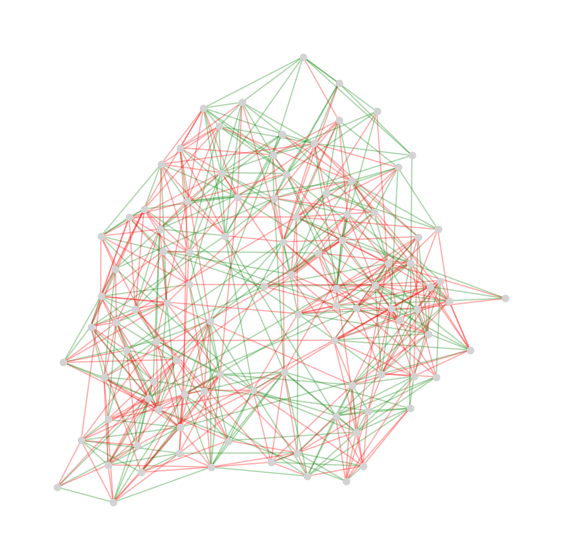

In [17]:
plot_network(model_polarized)

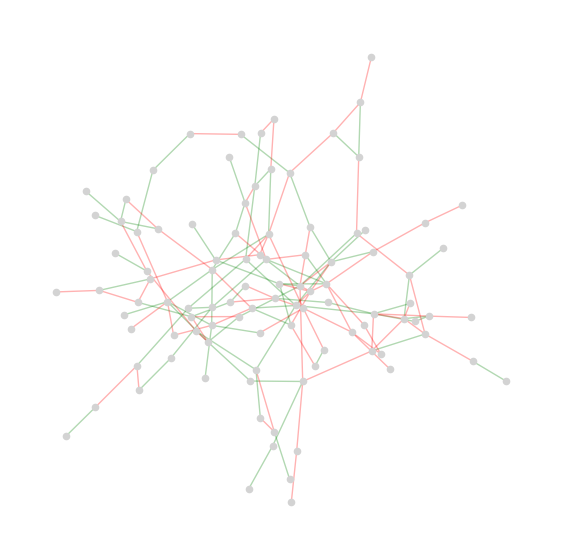

In [18]:
plot_network(model_not_polarized)

In [21]:
%%time
model_dont_care = PolarizationModelFast(
    N=100,
    lambda_avg=12,
    epsilon=0.175,
    G=9,
    alpha=0.5,
    beta=1.0,
    gamma=0.02,
    eta=0.5,
    symmetric_influencers=True,
)


psi_mean, psi_samples = model_dont_care.run_and_sample_polarization(
    burn_in_steps=2000,
    sample_dt=100,
    sample_rounds=30
)

print(f"Final ⟨k₊⟩ = {model_dont_care.get_positive_degree():.2f}")
print(f"Mean ψ = {psi_mean:.4f}")
print(f"Expected baseline (random): ψ = {1/9:.4f}")

Final ⟨k₊⟩ = 6.46
Mean ψ = 0.1165
Expected baseline (random): ψ = 0.1111
CPU times: user 1.22 s, sys: 3.46 ms, total: 1.23 s
Wall time: 1.23 s


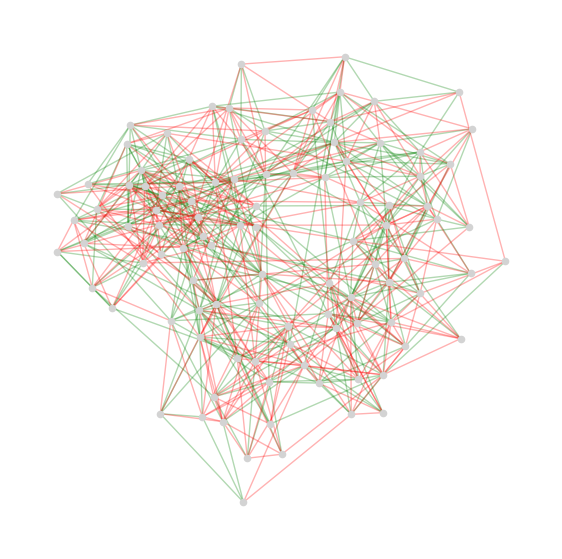

In [22]:
plot_network(model_dont_care)

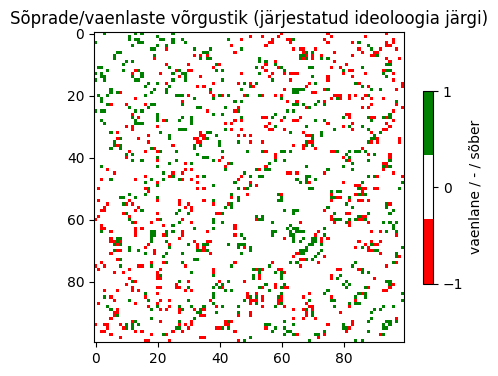

In [23]:
plot_relationship_heatmap_ordered(model_dont_care)

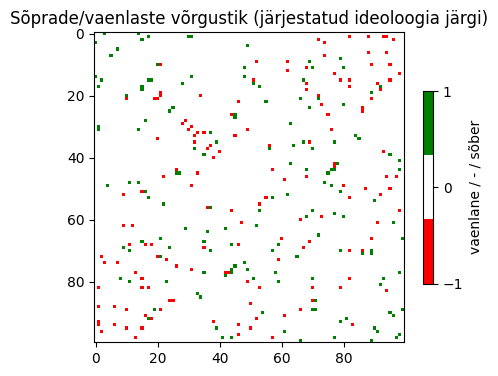

In [24]:
plot_relationship_heatmap_ordered(model_not_polarized)

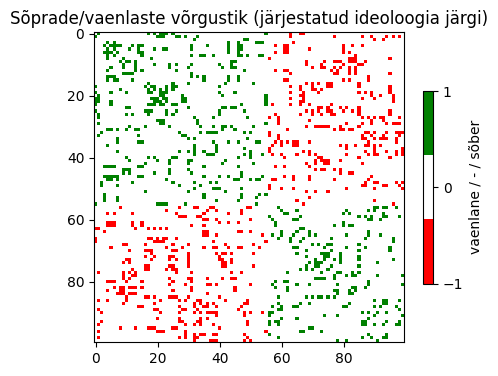

In [25]:
plot_relationship_heatmap_ordered(model_polarized)

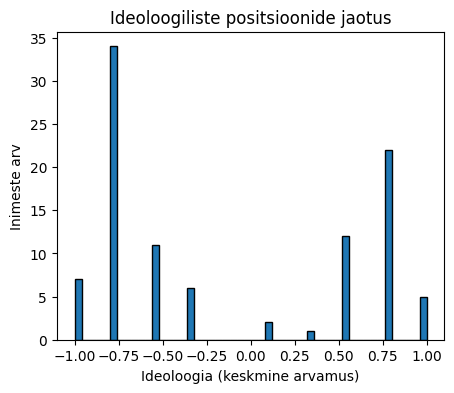

In [14]:
plot_ideology_distribution(model_polarized)

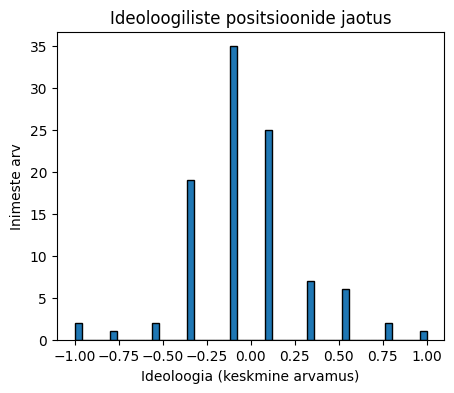

In [15]:
plot_ideology_distribution(model_not_polarized)

## Polarized with mode datapoints

In [45]:
%%time
model_polarized2 = PolarizationModelFast(
    N=90,
    lambda_avg=12,
    epsilon=0.175,
    G=9,
    alpha=0.5,
    beta=2.7,
    gamma=0.02,
    eta=0.5,
    symmetric_influencers=True,
)


psi_mean, psi_samples = model_polarized2.run_and_sample_polarization(
    burn_in_steps=2000,
    sample_dt=100,
    sample_rounds=30
)

print(f"Final ⟨k₊⟩ = {model_polarized2.get_positive_degree():.2f}")
print(f"Mean ψ = {psi_mean:.4f}")
print(f"Expected baseline (random): ψ = {1/9:.4f}")

Final ⟨k₊⟩ = 6.11
Mean ψ = 0.6244
Expected baseline (random): ψ = 0.1111
CPU times: user 552 ms, sys: 0 ns, total: 552 ms
Wall time: 552 ms


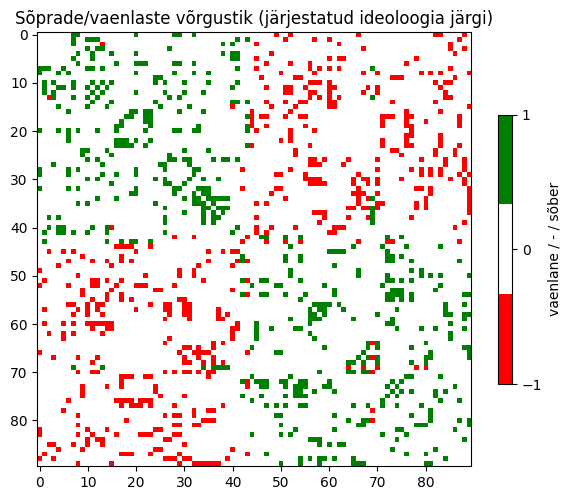

In [46]:
plot_relationship_heatmap_ordered(model_polarized2, figsize=(7, 7))

## Run experiments with the 2% radical influencers

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed:  5.5min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  5.6min remaining:   41.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.3min finished


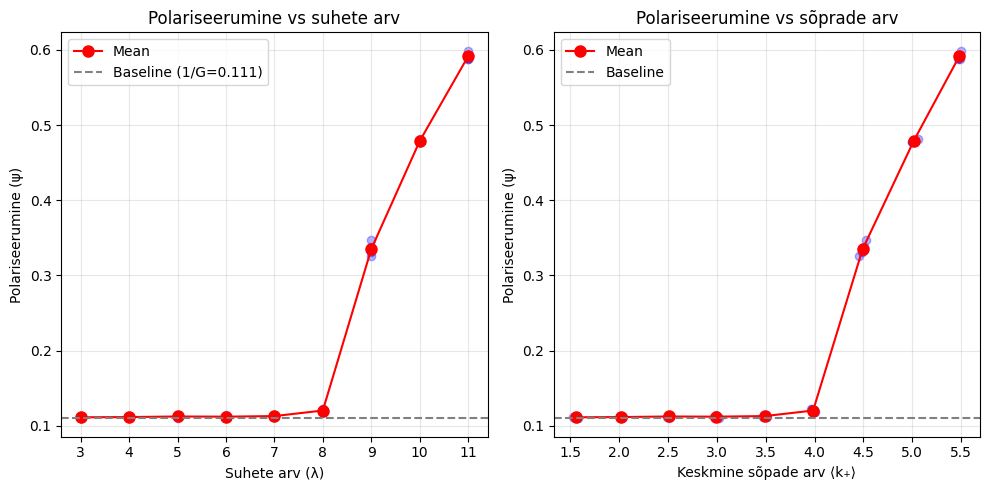

CPU times: user 1.16 s, sys: 51.8 ms, total: 1.22 s
Wall time: 6min 17s


In [16]:
%%time

experiment_base = PolarizationExperiment(
    #lambda_values=[6, 8, 10, 12, 14, 16],  # Range of connectivity values
    lambda_values=[3, 4, 5, 6, 7, 8, 9, 10, 11],  # Range of connectivity values
    N=10000,       # Smaller N for faster sweep
    G=9,
    alpha=0.5,
    beta=2.7,
    epsilon=0.175,
    gamma=0.02
)

df = experiment_base.run_experiment(
    burn_in_steps=1000,  # Shorter burn-in for sweep
    sample_dt=50,
    sample_rounds=20,
    n_repeats=5,
    n_jobs=-1  # Use all available cores
)

# Plot results
experiment_base.plot_results()

## Run experiment with no radical influencers

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  15 out of  27 | elapsed:  2.3min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:  3.3min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  21 out of  27 | elapsed:  3.4min remaining:   58.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:  3.5min remaining:   25.9s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.2min finished


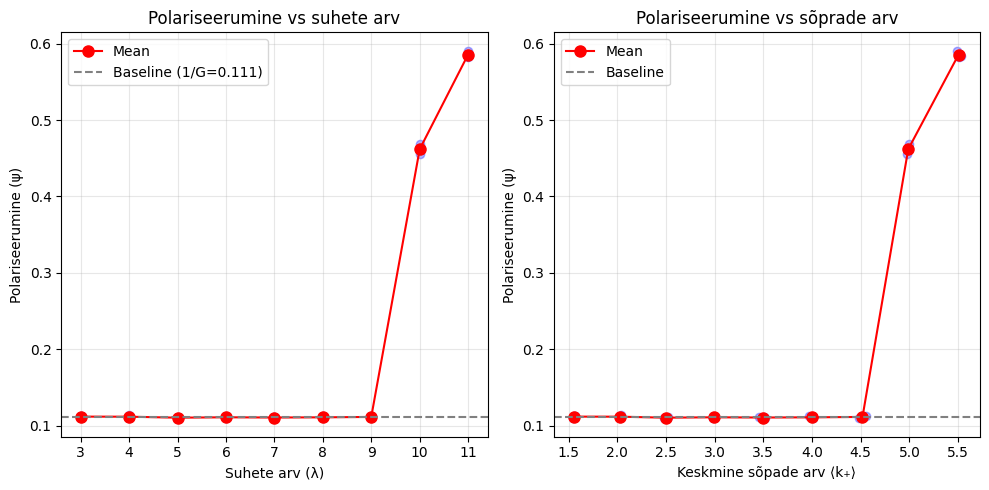

CPU times: user 855 ms, sys: 37.2 ms, total: 892 ms
Wall time: 4min 9s


In [17]:
%%time
experiment = PolarizationExperiment(
    #lambda_values=[6, 8, 10, 12, 14, 16],  # Range of connectivity values
    lambda_values=[3, 4, 5, 6, 7, 8, 9, 10, 11],  # Range of connectivity values
    N=10000,       # Smaller N for faster sweep
    G=9,
    alpha=0.5,
    beta=2.7,
    epsilon=0.175,
    gamma=0.0
)

df = experiment.run_experiment(
    burn_in_steps=1000,  # Shorter burn-in for sweep
    sample_dt=50,
    sample_rounds=20,
    n_repeats=3,
    n_jobs=-1  # Use all available cores
)

# Plot results
experiment.plot_results()

## Change alpha - more disagree with enemies

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  15 out of  27 | elapsed:  2.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:  2.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  21 out of  27 | elapsed:  3.0min remaining:   51.6s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:  3.1min remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.7min finished


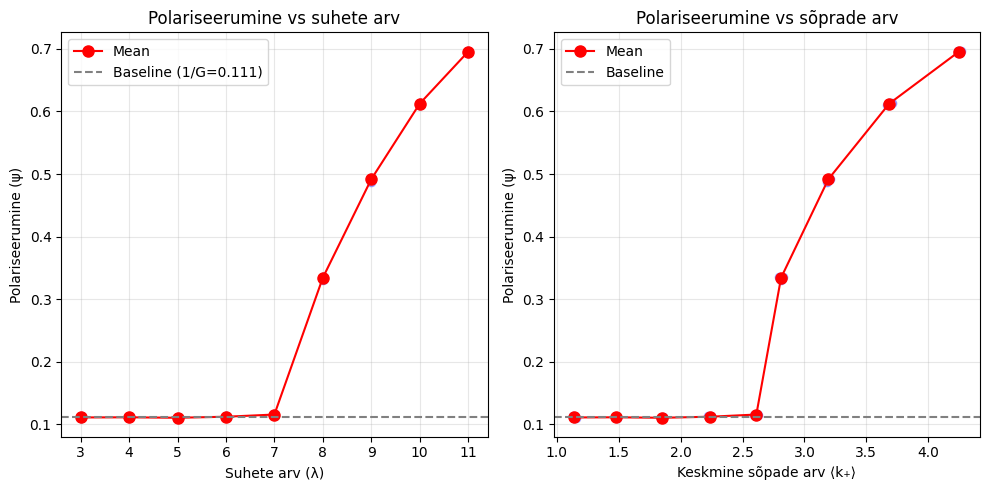

CPU times: user 815 ms, sys: 30.9 ms, total: 845 ms
Wall time: 3min 42s


In [18]:
%%time
experiment = PolarizationExperiment(
    #lambda_values=[6, 8, 10, 12, 14, 16],  # Range of connectivity values
    lambda_values=[3, 4, 5, 6, 7, 8, 9, 10, 11],  # Range of connectivity values
    N=10000,       # Smaller N for faster sweep
    G=9,
    alpha=0.25,
    beta=2.7,
    epsilon=0.175,
    gamma=0.02
)

# Run with 3 repeats per lambda value, using all CPU cores
df = experiment.run_experiment(
    burn_in_steps=1000,  # Shorter burn-in for sweep
    sample_dt=50,
    sample_rounds=20,
    n_repeats=3,
    n_jobs=-1  # Use all available cores
)

# Plot results
experiment.plot_results()

## Change alpha more agree with friends

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  15 out of  27 | elapsed:  1.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:  2.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  21 out of  27 | elapsed:  2.6min remaining:   44.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:  2.6min remaining:   19.7s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.2min finished


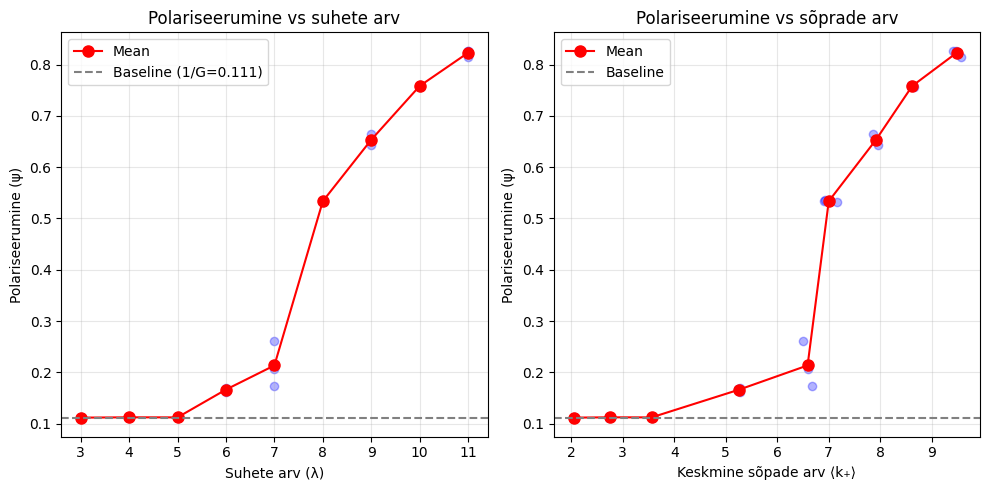

CPU times: user 890 ms, sys: 18.7 ms, total: 908 ms
Wall time: 3min 11s


In [19]:
%%time

experiment = PolarizationExperiment(
    #lambda_values=[6, 8, 10, 12, 14, 16],  # Range of connectivity values
    lambda_values=[3, 4, 5, 6, 7, 8, 9, 10, 11],  # Range of connectivity values
    N=10000,       # Smaller N for faster sweep
    G=9,
    alpha=0.75,
    beta=2.7,
    epsilon=0.175,
    gamma=0.02
)

# Run with 3 repeats per lambda value, using all CPU cores
df = experiment.run_experiment(
    burn_in_steps=1000,  # Shorter burn-in for sweep
    sample_dt=50,
    sample_rounds=20,
    n_repeats=3,
    n_jobs=-1  # Use all available cores
)

# Plot results
experiment.plot_results()

## Reduce beta - social sensitivity

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  15 out of  27 | elapsed:  2.7min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:  4.0min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  21 out of  27 | elapsed:  4.3min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:  4.6min remaining:   34.6s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  5.6min finished


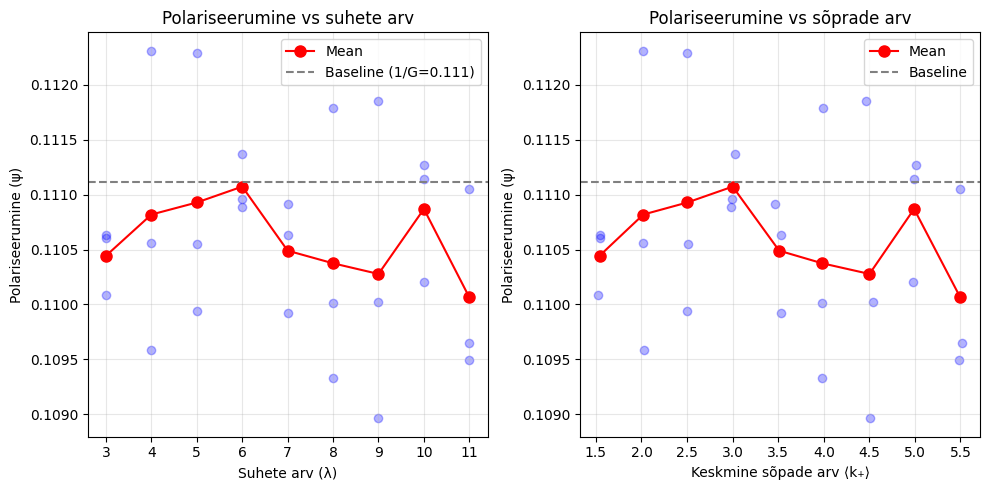

CPU times: user 1.02 s, sys: 22.2 ms, total: 1.04 s
Wall time: 5min 34s


In [20]:
%%time

experiment = PolarizationExperiment(
    #lambda_values=[6, 8, 10, 12, 14, 16],  # Range of connectivity values
    lambda_values=[3, 4, 5, 6, 7, 8, 9, 10, 11],  # Range of connectivity values
    N=10000,       # Smaller N for faster sweep
    G=9,
    alpha=0.5,
    beta=1.0,
    epsilon=0.175,
    gamma=0.0
)

# Run with 3 repeats per lambda value, using all CPU cores
df = experiment.run_experiment(
    burn_in_steps=1000,  # Shorter burn-in for sweep
    sample_dt=50,
    sample_rounds=20,
    n_repeats=3,
    n_jobs=-1  # Use all available cores
)

# Plot results
experiment.plot_results()

## Hysterisis effect

In [16]:
def run_hysteresis_experiment(lambda_start=11, lambda_end=3, n_steps=9, 
                               N=5000, G=9, alpha=0.5, beta=2.7, epsilon=0.175, gamma=0.0):
    """
    Start at high connectivity, let it polarize, then gradually reduce connectivity
    """
    lambda_values = np.linspace(lambda_start, lambda_end, n_steps)
    results = []
    
    # Initialize at high connectivity
    model = PolarizationModelFast(N=N, lambda_avg=lambda_start, epsilon=epsilon,
                                   G=G, alpha=alpha, beta=beta, gamma=gamma)
    
    # Burn in at high connectivity
    print(f"Burning in at λ={lambda_start}...")
    model.run_simulation(2000)
    
    # Now gradually reduce connectivity by removing edges
    for lam in lambda_values:
        print(f"Testing λ={lam:.1f}...")
        
        # Remove edges to reach target degree (simplified approach)
        current_deg = np.mean([model.network.degree(n) for n in model.network.nodes()])
        while current_deg > lam:
            # Remove a random edge
            edges = list(model.network.edges())
            if edges:
                edge = edges[np.random.randint(len(edges))]
                model.network.remove_edge(*edge)
                # Update neighbor arrays
                model._build_neighbor_arrays()
                model._init_relationships()
            current_deg = np.mean([model.network.degree(n) for n in model.network.nodes()])
        
        # Run and measure
        model.run_simulation(500)
        pol = model.calculate_polarization()
        kplus = model.get_positive_degree()
        
        results.append({'lambda': lam, 'polarization': pol, 'k_plus': kplus, 'direction': 'down'})
    
    return pd.DataFrame(results)

# Run it
df_down = run_hysteresis_experiment()

Burning in at λ=11...
Testing λ=11.0...
Testing λ=10.0...
Testing λ=9.0...
Testing λ=8.0...
Testing λ=7.0...
Testing λ=6.0...
Testing λ=5.0...
Testing λ=4.0...
Testing λ=3.0...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed:  5.9min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  6.1min remaining:   45.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.7min finished


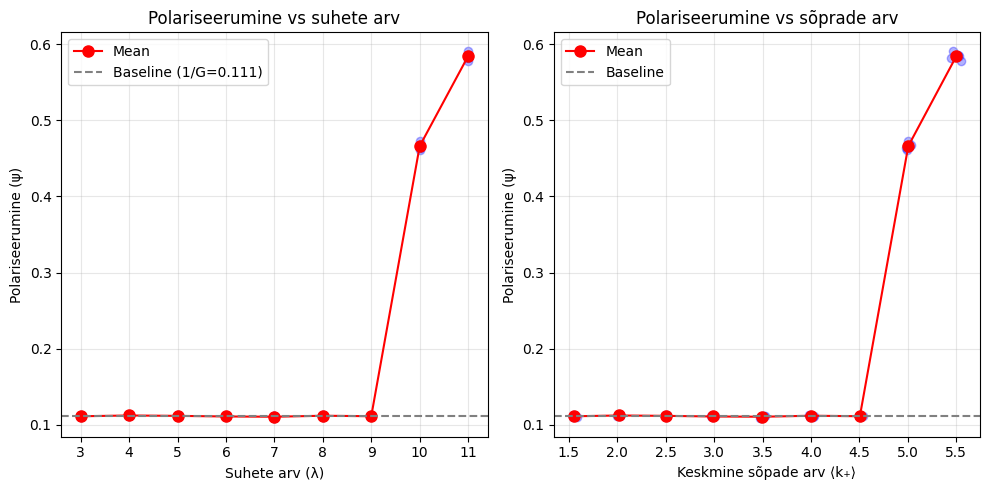

In [17]:
#get the base to compare with
experiment_base = PolarizationExperiment(
    #lambda_values=[6, 8, 10, 12, 14, 16],  # Range of connectivity values
    lambda_values=[3, 4, 5, 6, 7, 8, 9, 10, 11],  # Range of connectivity values
    N=10000,       # Smaller N for faster sweep
    G=9,
    alpha=0.5,
    beta=2.7,
    epsilon=0.175,
    gamma=0.0
)

df = experiment_base.run_experiment(
    burn_in_steps=1000,  # Shorter burn-in for sweep
    sample_dt=50,
    sample_rounds=20,
    n_repeats=5,
    n_jobs=-1  # Use all available cores
)

# Plot results
experiment_base.plot_results()

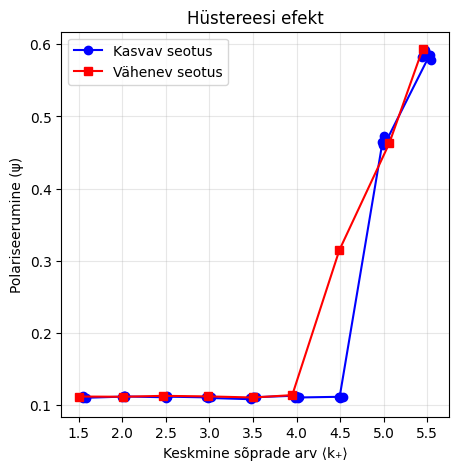

In [18]:
plt.figure(figsize=(5, 5))
plt.plot(df['k_plus'], df['polarization'], 'bo-', label='Kasvav seotus')
plt.plot(df_down['k_plus'], df_down['polarization'], 'rs-', label='Vähenev seotus')
plt.xlabel('Keskmine sõprade arv ⟨k₊⟩')
plt.ylabel('Polariseerumine (ψ)')
plt.title('Hüstereesi efekt')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Increase number of topics

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed: 17.9min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed: 19.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 22.6min finished


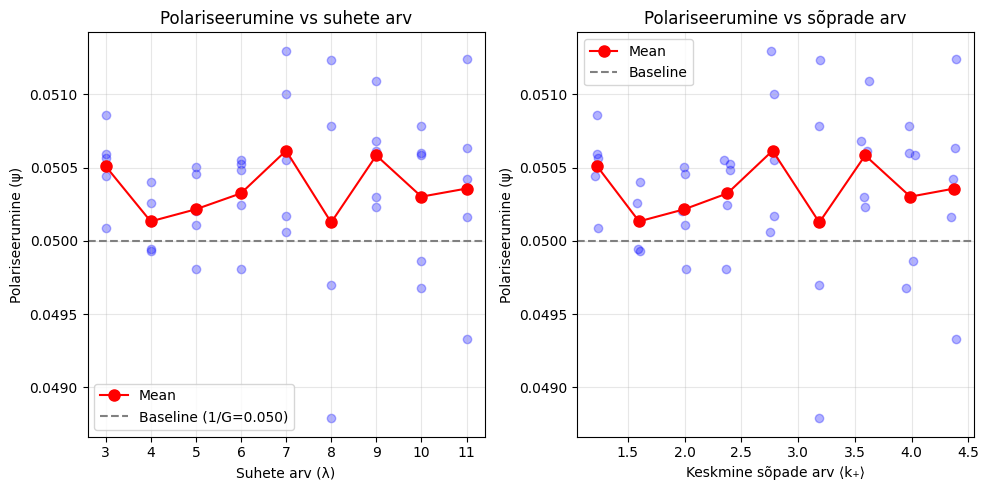

CPU times: user 3.55 s, sys: 73.9 ms, total: 3.62 s
Wall time: 22min 37s


In [24]:
%%time

experiment_more_topics = PolarizationExperiment(
    #lambda_values=[6, 8, 10, 12, 14, 16],  # Range of connectivity values
    lambda_values=[3, 4, 5, 6, 7, 8, 9, 10, 11],  # Range of connectivity values
    N=10000,       # Smaller N for faster sweep
    G=20,
    alpha=0.5,
    beta=2.7,
    epsilon=0.175,
    gamma=0.02
)

df = experiment_more_topics.run_experiment(
    burn_in_steps=1000,  # Shorter burn-in for sweep
    sample_dt=50,
    sample_rounds=20,
    n_repeats=5,
    n_jobs=-1  # Use all available cores
)

# Plot results
experiment_more_topics.plot_results()

## Network with 2% radical influencers but powerlaw

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  57 out of  65 | elapsed:  7.3min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  8.0min finished


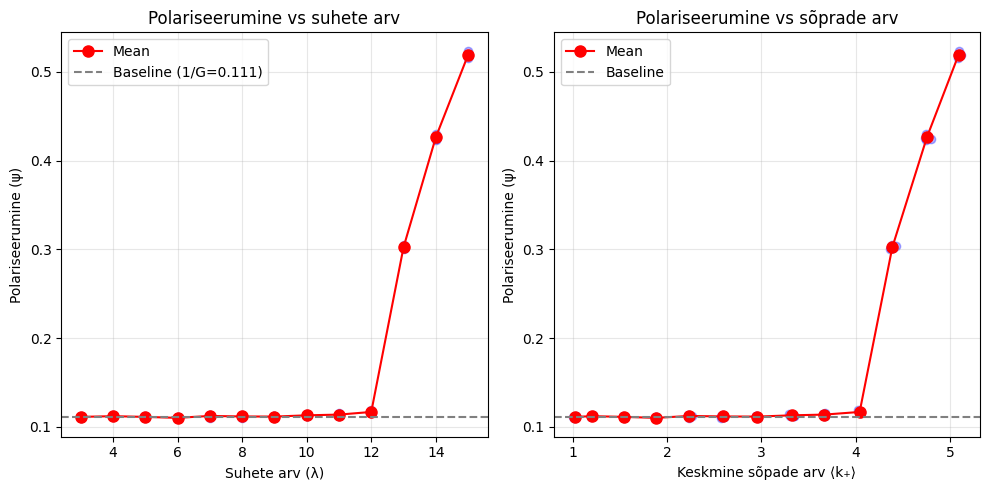

CPU times: user 1.68 s, sys: 65.4 ms, total: 1.74 s
Wall time: 8min


In [59]:
%%time

experiment_base_power = PolarizationExperiment(
    #lambda_values=[6, 8, 10, 12, 14, 16],  # Range of connectivity values
    lambda_values=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],  # Range of connectivity values
    N=10000,       # Smaller N for faster sweep
    G=9,
    alpha=0.5,
    beta=2.7,
    epsilon=0.175,
    gamma=0.02,

)

df = experiment_base_power.run_experiment(
    burn_in_steps=1000,  # Shorter burn-in for sweep
    sample_dt=50,
    sample_rounds=20,
    n_repeats=5,
    n_jobs=-1,  # Use all available cores
    network_type='power'
)

# Plot results
experiment_base_power.plot_results()